In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


It is often a good idea to start gathering all information about the data we are trying to use. We will try to extract three layers of information from this dataset. Just to make it easier for us to do this, it is a good idea to wrap these commands into a function **get_dataset_details**. 

Here is a function that prints all the relevant details about the data.

* df.info() provides details about the non-null entries in each column of the dataframe
* df.describe() lists down all the relevant statistical features about the dataset like count, mean, standard deviation
* df.hist(), with "bins" argument, plots how each of the features are distrbuted

In [232]:
def get_dataset_details(df):
    print(df.info(),'\n')
    print(df.describe(),'\n')
    plt.show();

In [233]:
get_dataset_details(casp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB
None 

               RMSD            F1            F2            F3            F4  \
count  45730.000000  45730.000000  45730.000000  45730.000000  45730.000000   
mean       7.748528   9871.596995   3017.367175      0.302392    103.492433   
std        6.118312   4058.138034   1464.324663      0.062886     55.424985   
min        0.000000   2392.050000    403.500000      0.092500     10.31010

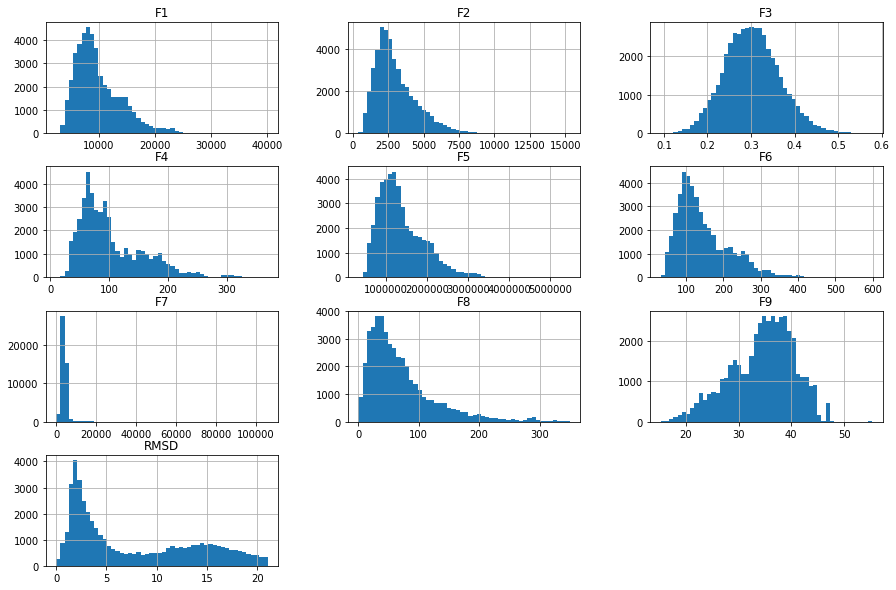

In [234]:
casp.hist(bins=50, figsize=(15,10));

Let us see if there is any missing data in the dataset

In [235]:
np.where(casp.values == np.nan)

(array([], dtype=int64), array([], dtype=int64))

In [236]:
def get_correlation(data):
    plt.figure(figsize=(15,10));
    pd.plotting.scatter_matrix(data, figsize=(20,10));

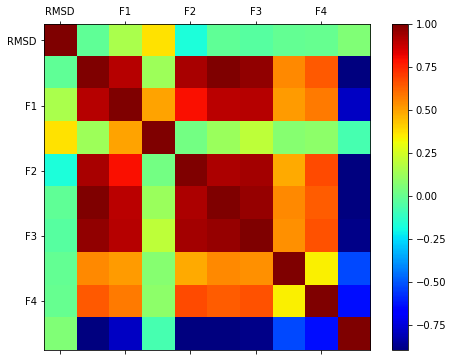

In [237]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(casp.corr(), cmap = 'jet', interpolation='none')
fig.colorbar(cax)

ax.set_xticklabels(['']+list(casp));
ax.set_yticklabels(['']+list(casp));

<Figure size 1080x720 with 0 Axes>

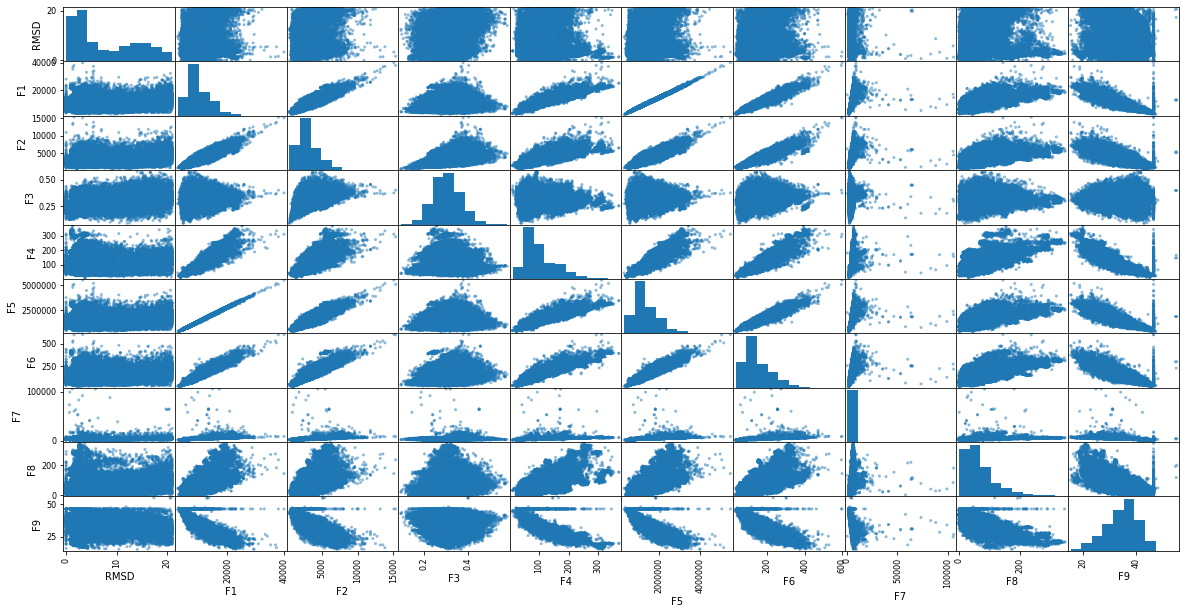

In [238]:
get_correlation(casp)

Let us spend some time on this plot and discuss what we see:

1. The target value in this case, `RMSD` is not seen to be linearly correlating with any of the features. 

2. Some of the features are very well correlated with each other. For example, `F1`, `F2`, `F4`, `F5` and `F6` seems to positively correlated. It is worthwhile to spend time in reducing the dimensionality of this data for better results.

3. From the correlations plots, let us pay more attention to feature `F9`. It can be easily noted that the values near ~50 have been capped artificially. Going back to the histogram plot, it is clear that we see a bin corresponding to this value. At this point, it is good to get rid of this data.

4. If you pay more attention to `F7`, you will notice that this is a highly tail-heavy distribution and it would be worthwhile to explore more about this.

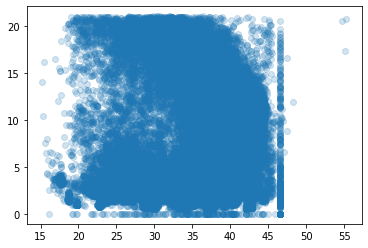

In [84]:
plt.scatter(casp["F9"], casp["RMSD"], alpha=0.2)

In [85]:
casp_cleaned = casp[casp['F9']<46]
casp_cleaned = casp_cleaned[casp_cleaned["RMSD"] > 0.1]
casp_cleaned = casp_cleaned.reset_index().drop("index", axis=1)

In [86]:
casp_cleaned.corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.374106
F2      0.158303
F9      0.074419
F8     -0.002169
F7     -0.002646
F5     -0.013008
F1     -0.014002
F6     -0.035606
F4     -0.170617
Name: RMSD, dtype: float64

In [61]:
casp.corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.374309
F2      0.156895
F9      0.062830
F8      0.000344
F7     -0.003339
F5     -0.013982
F1     -0.015087
F6     -0.036135
F4     -0.169771
Name: RMSD, dtype: float64

# Fit a linear regression model

Let us start with splitting the dataset into training set and test set. We will make use of Pipeline function from scikitlearn to be able to do scaling of the data and add polynomial features. 

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp_cleaned.drop("RMSD", axis=1),casp_cleaned["RMSD"], test_size=0.3, random_state=42)

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

poly_features_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("minmax_scaler", MinMaxScaler())
])

X_train_scaled = poly_features_pipeline.fit_transform(X_train)

In [97]:
X_train_scaled.shape

(31543, 54)

In [65]:
print("Number of Features in the set " + str(X_train_scaled.shape[1]))

Number of Features in the set 219


We ended up with 219 features altogether. How did this happen? 

The formula to calculate the total number of polynomial features after transormation is *C(n+r,r)* (Combination), where *n* is the number of features in the dataset and *r* is the degree of polynomial. In our case, this translates to $C(9+3,3) = 12!/ (12-3)! 3! = 220$. Since we did not opt for the bias term, we ended up with one less than 220, i.e., 219.

In [98]:
from sklearn.linear_model import LinearRegression
import time
lin_reg = LinearRegression();

start_time = time.time()
lin_reg.fit(X_train_scaled, y_train)
print('Time taken ' + str(time.time() - start_time))

Time taken 0.1363358497619629


In [109]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(5,5))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y_pred.min(),y_pred.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(r2_score(lin_reg_model.predict(X), y)))
    plt.savefig(name+'.svg', format='svg')

In [100]:
X_test_scaled = poly_features_pipeline.fit_transform(X_test)

In [101]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(lin_reg.predict(X_test_scaled),y_test))
rmse_train = np.sqrt(mean_squared_error(lin_reg.predict(X_train_scaled),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  4.850188274741152 21.462816110285008


In [106]:
r2_model_score = r2_score(lin_reg.predict(X_test_scaled), y_test)

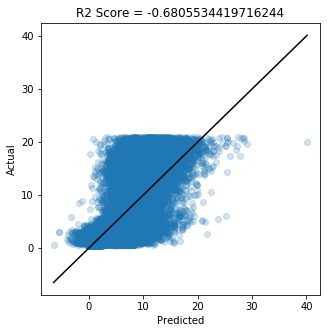

In [110]:
plot_results(X_train_scaled, y_train, lin_reg, "Without_PCA_Train")

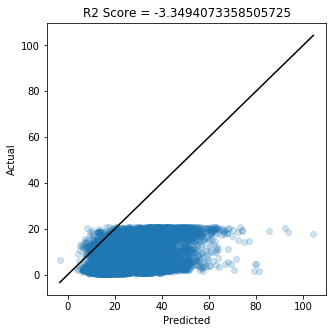

In [111]:
plot_results(X_test_scaled, y_test, lin_reg, "Without_PCA_Test")

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp_cleaned.drop("RMSD", axis=1),casp_cleaned["RMSD"], test_size=0.3, random_state=42)

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("pca", PCA(n_components=0.99))
])
X_train_scaled = scaler_pipeline.fit_transform(X_train)

In [115]:
pca_handle = scaler_pipeline.named_steps['pca']
pca_handle.explained_variance_ratio_.sum()

0.9933532246312039

In [116]:
X_train_scaled.shape

(31543, 5)

In [117]:
from sklearn.neural_network import MLPRegressor
import time
mlp_reg = MLPRegressor(random_state=48, max_iter=100, verbose=True);

start_time = time.time()
mlp_reg.fit(X_train_scaled, y_train)
print('Time taken ' + str(time.time() - start_time))

Iteration 1, loss = 38.97380258
Iteration 2, loss = 19.77356786
Iteration 3, loss = 15.29573385
Iteration 4, loss = 14.51494328
Iteration 5, loss = 14.04089993
Iteration 6, loss = 13.76519891
Iteration 7, loss = 13.56678574
Iteration 8, loss = 13.40873364
Iteration 9, loss = 13.28957943
Iteration 10, loss = 13.20018069
Iteration 11, loss = 13.12757660
Iteration 12, loss = 13.06744036
Iteration 13, loss = 13.01704246
Iteration 14, loss = 12.96843276
Iteration 15, loss = 12.92754030
Iteration 16, loss = 12.88725080
Iteration 17, loss = 12.85106285
Iteration 18, loss = 12.82037443
Iteration 19, loss = 12.78685916
Iteration 20, loss = 12.75743854
Iteration 21, loss = 12.73446093
Iteration 22, loss = 12.71465397
Iteration 23, loss = 12.69053499
Iteration 24, loss = 12.66879274
Iteration 25, loss = 12.65300315
Iteration 26, loss = 12.63729331
Iteration 27, loss = 12.61559364
Iteration 28, loss = 12.60106777
Iteration 29, loss = 12.58731080
Iteration 30, loss = 12.57443634
Iteration 31, loss 

/opt/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


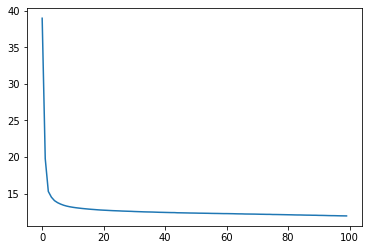

In [118]:
plt.plot(mlp_reg.loss_curve_)

In [119]:
X_test_scaled = scaler_pipeline.transform(X_test)

In [120]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(mlp_reg.predict(X_test_scaled),y_test))
rmse_train = np.sqrt(mean_squared_error(mlp_reg.predict(X_train_scaled),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  4.886503131939888 4.857518815549432


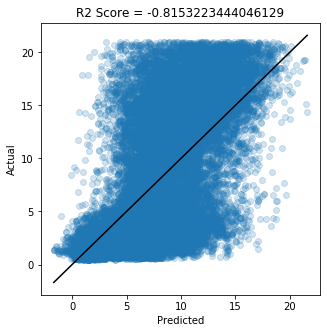

In [122]:
plot_results(X_train_scaled, y_train, mlp_reg, "Without_PCA_Train")

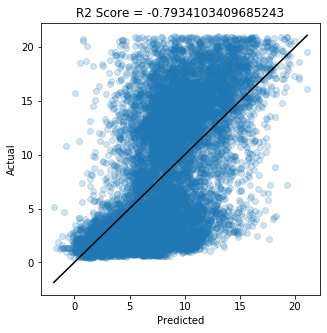

In [121]:
plot_results(X_test_scaled, y_test, mlp_reg, "Without_PCA_Test")